## Ćwiczenie 6 - Sieć CNN
Maciej Dutkowski 260396

### Import i analizana danych

In [40]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import warnings

In [41]:
warnings.filterwarnings('ignore')

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

data = torchvision.datasets.FashionMNIST('./test', download = True, transform=transform)
data_loader = torch.utils.data.DataLoader(data,
 batch_size=8,
 shuffle=True)

Dane zostają pobrane z datasetu torchvision FashionMNIST i zapisane w pamięci. 

In [3]:
print("Data set size:", len(data))

Data set size: 60000


Próbek jest 60 000.

In [4]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Klas 10 i każda z nich reprezentuje jeden typ ubrań.

In [5]:
dataiter = iter(data_loader)
images, labels = next(dataiter)

print("Label : ", labels[0], classes[labels[0]])
print("Image size : ", images.size())
print("Image row : ", images[0][0][14])

Label :  tensor(8) Bag
Image size :  torch.Size([8, 1, 28, 28])
Image row :  tensor([-0.2235, -0.0510,  0.0118, -0.3725, -0.1686, -0.3333, -0.4980, -0.5765,
        -0.4824, -0.4510, -0.4588, -0.4353, -0.4196, -0.4353, -0.4196, -0.4275,
        -0.4745, -0.4824, -0.4745, -0.4196, -0.3255, -0.3333, -0.1922, -0.4510,
        -0.5765, -0.1529, -0.1216, -1.0000])


Jak widać każda z próbek jest czarnobiałym obrazkiem o rozmiarach 28x28. Wartość każdego z pikseli jest zakresu od 0 do 1 i oznacza jego jasność. Na potrzeby nauki sieci neuronowej zostały znormalizowane do wartości od -1 do 1, gdyż takie wartości są efektywniejsze do treningu. Etykieta jest liczbą całkowitą, która reprezentuje jedną z 10 klas.

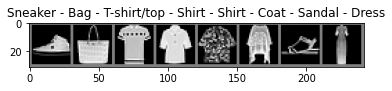

In [6]:
def imshow(img, labels):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(" - ".join([classes[labels[j]] for j in range(labels.size(0))]))
    plt.show()

dataiter = iter(data_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images), labels)

Zdjęcia ładowane są po określonym rozmiarze batcha (w tym przypadku 8). Jak widać są czarno białe i małej rozdzielczości, ale zazwyczaj proste do klasyfikacji dla człowieka.

### Przygotowanie danych i konfiguracja sieci

In [13]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torch.nn import LazyLinear
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [27]:
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

print("Training set size :", len(trainset))
print("Test set size :", len(testset))

Training set size : 60000
Test set size : 10000


Na początku dane zostały podzielone na zbiór do trenowania i testowania. Jak widać zbiór treningowy ma 60000 próbek a testowy 10000.

In [28]:
def train_model(model, trainloader, optimizer, epochs=3):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(trainloader)}")
    print('Finished Training')

Została zdefiniowana funkcja przeprowadzająca trenowanie modelu dla podenaj liczby epok.

In [29]:
def test_model(model, testloader):
    model.eval()
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            true_labels.extend(labels.numpy())
            pred_labels.extend(predicted.numpy())

    accuracy = accuracy_score(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')
    print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

Oraz funkcja testująca model

### Badanie różnych konfiguracji sieci CNN

##### Liczba kanałów sieci

Na początku została zdefiniowana prosta sieć CNN korzystająca z jednej warstwy konwolucyjnej, posiadającej 8 kanałów wyjściowych. Jej rezultat następnie jest spłaszany przez wartstwę LazyLinear, która podczas działania sieci sprawdza jaką ilość cech wyprodukowały warstwy konwolucyjne, dzięki temu nie musimy liczyć jakie wymiary ma wyjście z warstwy konwolucujnej. Funkcją aktywacji dla warstwy konwolucyjnej jest ReLU. Z racji na to, że obrazki są czarno białe pierwsza warstwa konwulucyjna przyjmuje jeden kanał, rozmiar filtra dla testów wpływu liczby kanałów został ustawiony na 3.

In [36]:
class CNN_chanel_8(nn.Module):
    def __init__(self):
        super(CNN_chanel_8, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.fc2 = LazyLinear(10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(x.size(0), -1)
        x = self.fc2(x)
        return x

In [33]:
net = CNN_chanel_8()
optimizer = optim.Adam(net.parameters(), lr=0.01)
train_model(net, trainloader, optimizer)
test_model(net, testloader)

Epoch 1/3, Loss: 0.4744812678893407
Epoch 2/3, Loss: 0.36587257718046506
Epoch 3/3, Loss: 0.33350485565861065
Finished Training
Accuracy: 0.8439, Precision: 0.8490, Recall: 0.8439, F1 Score: 0.8389


Jak widać dla jednej prostej warstwy konwolucyjnej wyniki nie są oszałamiające. Natępnie dla teh samej sieci zwiększono liczbę kanałów do 16.

In [38]:
class CNN_chanel_16(nn.Module):
    def __init__(self):
        super(CNN_chanel_16, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.fc2 = LazyLinear(10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(x.size(0), -1)
        x = self.fc2(x)
        return x

In [42]:
net = CNN_chanel_16()
optimizer = optim.Adam(net.parameters(), lr=0.01)
train_model(net, trainloader, optimizer)
test_model(net, testloader)

Epoch 1/3, Loss: 0.48505983301997185
Epoch 2/3, Loss: 0.36375930921584365
Epoch 3/3, Loss: 0.3193913740317027
Finished Training
Accuracy: 0.8604, Precision: 0.8619, Recall: 0.8604, F1 Score: 0.8604


Doprowadziło to do uzykania trochę lepszych rezultatów, kosztem nieco dłuższego czasu trenowania(około 5%). Następnie dodano jeszcze jedną wartwę konwolucyjną o liczbie kanałów 16.

In [44]:
class CNN_chanel_16_16(nn.Module):
    def __init__(self):
        super(CNN_chanel_16_16, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        self.fc2 = LazyLinear(10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.fc2(x)
        return x

In [45]:
net = CNN_chanel_16_16()
optimizer = optim.Adam(net.parameters(), lr=0.01)
train_model(net, trainloader, optimizer)
test_model(net, testloader)

Epoch 1/3, Loss: 0.4580534788409869
Epoch 2/3, Loss: 0.36928298967878026
Epoch 3/3, Loss: 0.32566221317698557
Finished Training
Accuracy: 0.8645, Precision: 0.8678, Recall: 0.8645, F1 Score: 0.8652


Jak widać czas trenowania wzrósł prawie dwukrotnie, a dokładność modelu poprawiła się w bardzo niewielkim stopniu.

##### Rozmiar filtra

Dla wcześniejszej dwuwartwowej sieci CNN rozmiar filtra został zmniejszony z 3 do 2.

In [51]:
class CNN_chanel_16_16_filter_1(nn.Module):
    def __init__(self):
        super(CNN_chanel_16_16_filter_1, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, 2, padding=1)
        self.fc2 = LazyLinear(10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.fc2(x)
        return x

In [52]:
net = CNN_chanel_16_16_filter_1()
optimizer = optim.Adam(net.parameters(), lr=0.01)
train_model(net, trainloader, optimizer)
test_model(net, testloader)

Epoch 1/3, Loss: 0.4292094739953677
Epoch 2/3, Loss: 0.3249943337261677
Epoch 3/3, Loss: 0.2965090578258038
Finished Training
Accuracy: 0.8700, Precision: 0.8722, Recall: 0.8700, F1 Score: 0.8700


Skutkowało to trochę lepszym wynikiem, następnie sieć została zmieniona w następujący sposób - pierwsza wartstwa CNN filtr 2, druga warstwa CNN filtr 4. Takie podejście miało by umożliwić sieci w pierszej wartstwie analizę cech na bardzo niskim poziomie (obrazki 2x2), a następnie w następnym poziomie bardziej globalnie.

In [56]:
class CNN_chanel_16_16_filter_4(nn.Module):
    def __init__(self):
        super(CNN_chanel_16_16_filter_4, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, 4, padding=1)
        self.fc2 = LazyLinear(10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.fc2(x)
        return x

In [57]:
net = CNN_chanel_16_16_filter_4()
optimizer = optim.Adam(net.parameters(), lr=0.01)
train_model(net, trainloader, optimizer)
test_model(net, testloader)

Epoch 1/3, Loss: 0.4130135441323121
Epoch 2/3, Loss: 0.3232943566888571
Epoch 3/3, Loss: 0.29683654473125937
Finished Training
Accuracy: 0.8854, Precision: 0.8845, Recall: 0.8854, F1 Score: 0.8833


Jak widać pozwoliło to na uzyksanie bardzo dobrych wyników.

##### Rozmiar okna poolingu

Do uzyzkanej sieci została dodana operacja poolingu 2x2 na każdej z z dwóch warstw konwolucyjnych. Takie podejście powinno skrócić czas trenowania i umożliwić większą generalizację, ale równocześnie może utrudnić proces uczenie (przez eliminację istotnych cech). W testach jest stosowana operacja MaxPool2d, która przypisuje maksymalną wartość z danego obszaru.

In [60]:
class CNN_chanel_16_16_filter_4_pool_1(nn.Module):
    def __init__(self):
        super(CNN_chanel_16_16_filter_4_pool_1, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, 4, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc2 = LazyLinear(10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc2(x)
        return x

In [61]:
net = CNN_chanel_16_16_filter_4_pool_1()
optimizer = optim.Adam(net.parameters(), lr=0.01)
train_model(net, trainloader, optimizer)
test_model(net, testloader)

Epoch 1/3, Loss: 0.4331348958333333
Epoch 2/3, Loss: 0.3637648702740669
Epoch 3/3, Loss: 0.3456597083012263
Finished Training
Accuracy: 0.8754, Precision: 0.8743, Recall: 0.8754, F1 Score: 0.8737


Jak widać pooling 2x2 nie wpłynął znacząco ani na wyniki sieci ani na czas przetwarzania. Co ciekawe czas się nawet minimalnie wydłużył, co mogło być spowodowane tym, że same operacja poolingu zużywa trochę mocy obliczeniowej. Następnie został ustawiony pooling na poziomie 4x4.

In [63]:
class CNN_chanel_16_16_filter_4_pool_2(nn.Module):
    def __init__(self):
        super(CNN_chanel_16_16_filter_4_pool_2, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, 4, padding=1)
        self.pool = nn.MaxPool2d(4, 4)
        self.fc2 = LazyLinear(10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc2(x)
        return x

In [64]:
net = CNN_chanel_16_16_filter_4_pool_2()
optimizer = optim.Adam(net.parameters(), lr=0.01)
train_model(net, trainloader, optimizer)
test_model(net, testloader)

Epoch 1/3, Loss: 0.7008380393425624
Epoch 2/3, Loss: 0.5566827425161998
Epoch 3/3, Loss: 0.5201630196332931
Finished Training
Accuracy: 0.7939, Precision: 0.8023, Recall: 0.7939, F1 Score: 0.7920


Dla tego rozwiązania czas trenowania skrócił się już znacznie, ale kosztem dokładności modelu. Możliwe, że istotny pozytywny wpływ poolingu był by widoczny przy uczeniu przez większą ilość epok i dla głębszych sieci.

#### W zależności od zaburzenia danch

Następnie obrazy zostały zaburzone szumem gaussowskim. W teorii może to pozwolić na lepszą generalizację modelu i ograniczenie efektu przeuczenia, jednak może również utrudnić (a nawet uniemożliwić) i wydłużyć naukę.

In [68]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.mean = mean
        self.std = std
    
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [69]:
transform_gaussian = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    AddGaussianNoise(0., 0.1)
])
trainset_gaussian = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_gaussian)
testset_gaussian = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_gaussian)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


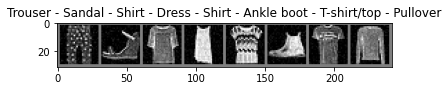

In [70]:
data_loader_gaussian_test = torch.utils.data.DataLoader(trainset_gaussian,
 batch_size=8,
 shuffle=True)

dataiter = iter(data_loader_gaussian_test)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images), labels)

In [74]:
testloader_gaussian = torch.utils.data.DataLoader(testset_gaussian,
 batch_size=32,
 shuffle=False)

trainloader_gaussian = torch.utils.data.DataLoader(trainset_gaussian,
 batch_size=32,
 shuffle=True)

In [75]:
net = CNN_chanel_16_16_filter_4()
optimizer = optim.Adam(net.parameters(), lr=0.01)
train_model(net, trainloader_gaussian, optimizer)
test_model(net, testloader_gaussian)

Epoch 1/3, Loss: 0.4918632583538691
Epoch 2/3, Loss: 0.37150511441628137
Epoch 3/3, Loss: 0.3537885657548904
Finished Training
Accuracy: 0.8610, Precision: 0.8613, Recall: 0.8610, F1 Score: 0.8603


Jak widać zaburzenie danych szumem gausowskim nie miało istotnego wpływu na wynik sieci, a wręcz lekko go pogorszyło. Możliwe, że pozytywne skutki takiego roizwiązania byłyby widoczne przy uczeniu przez większą ilość epok.